In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

AMS 241, Problem Set 1, Problem 2

Zachary Jennings

Consider a DP prior $DP(\alpha,G_0)$ with $G_0 = N(0,1)$. 

In [240]:
class DP(object):
    '''
    Class to hold a DP prior.
    '''
    def __init__(self,g='foo',alpha=1.,func_type='normal',**kwargs):
        '''
        Parameters:
        g: scipy.stats object. if not specified, function type is used
        alpha: precision parameter for dirichlet distribution
        '''    
        self.alpha = alpha
        
        #check if custom function is passed, else use that specified
        if g == 'foo':
            if func_type == 'normal':
                self.g = stats.norm(**kwargs)
            elif func_type == 'uniform':
                self.g = stats.uniform(**kwargs)
            else:
                print 'Error: No valid function supplied or specified.'
                
        else:
            self.g = g
        
        
    def DrawCDFFerg(self,grid=np.linspace(-4,4,100),n_cdf=1):
        '''
        Draw a CDF realization, using method of Fergueson 1973
        Parameters:
            grid: n x 1 space of values on which to draw Dirichlet values
            
            n_cdf: int
                number of CDFs to generate
        
        '''
        g_draws = self.g.cdf(grid)
        g_draws = np.insert(g_draws,[0],[0.])
        g_diff = g_draws[1:] - g_draws[:-1]
        
        cdf_arr = []
        for i in range(n_cdf):
            p = np.cumsum(stats.dirichlet.rvs(self.alpha*g_diff))
            cdf_arr.append(CDF(grid,p))
        
        return cdf_arr
    
    def DrawCDFStick(self,n_cdf=1,e=0.001,n_max=1e4):
        '''
        Draw a CDF realization, using stick-breaking constructive method.
        Stop occurs using error-tolerance stop.
        '''
        #generate lists to hold the relevant values
        cdf_arr = []
        beta = stats.beta(1,self.alpha)
        
        #start the primary cdf generation loop
        for i in range(n_cdf):
            x = []
            p = []
            z = []
            z.append(beta.rvs())
            x.append(self.g.rvs())
            p.append(z[0])
            
            #iterate for stick breaking process with appropriate exit conditions
            while (self.alpha/(1.+self.alpha))**len(x) > e and len(x) < n_max:
                x.append(self.g.rvs())
                this_z = beta.rvs()
                this_w = np.prod(1.-np.array(z))
                p.append(this_w * this_z)
                
                z.append(this_z)
    
                if len(x) >= n_max:
                    print 'Max iterations exceeded, exiting generation loop'

                
            self.x = x
            self.z = z
            self.p = p
                
            sort_x = np.argsort(x)
            x = np.array(x)[sort_x]
            p = np.cumsum(np.array(p)[sort_x])
            cdf_arr.append(CDF(x,p))
            
            
        return cdf_arr
    
    def PlotCDFs(self,cdf_arr,grid=np.linspace(-4,4,100),**kwargs):
        '''
        Plot a list of CDFs for values of grid
        Parameters:
            cdf_arr: list of CDF objects
            grid: x-grid for plotting
        '''
        fig,ax = plt.subplots()
        ax.set_ylim(0.,1.)
        
        for i in cdf_arr:
            p = map(i.GetProb,grid)
            ax.plot(grid,p,**kwargs)
        
        
class CDF(object):
    '''
    Class to hold a single 1D discrete, DP-generated CDF
    '''
    def __init__(self,x,p):
        '''
        Parameters:
        x: n x 1 array where 
        p: n x 1 array which holds P(X < x)
        '''
        self.x = np.array(x)
        self.cdf = np.array(p)
        self.pdf = self.cdf - np.insert(self.cdf,0.,0.)[:-1]
        
    def GetProb(self,check_x):
        '''
        Return P(x < check_x)
        '''
        #if check_x is below the region where the CDF is defined, make sure to return 0.     
        if np.all(check_x < self.x):
            return 0.0
                
        if np.all(check_x > self.x):
            return 1.0
        
        diff = check_x - self.x
        mask = diff < 0.
        
        masked_diff = np.ma.masked_array(diff, mask)
        return self.p[masked_diff.argmin()]
    
    def GetMean(self):
        '''
        Return the mean (weighted average) of the distributuion
        '''
        return np.sum(self.pdf * self.x)/np.sum(self.pdf)
    
    def GetSD(self):
        '''
        Return the weighted variance of the distribution
        '''
        return np.sum(self.pdf * (self.x - self.GetMean())**2)/np.sum(self.pdf)


In [255]:
dp = DP(alpha=1000.)
cdf_arr = dp.DrawCDFFerg(n_cdf=1000)
means = []
stddevs = []
for i in cdf_arr:
    means.append(i.GetMean())
    stddevs.append(i.GetSD())

(array([   1.,    2.,    7.,    5.,   22.,   34.,   37.,   55.,   71.,
          84.,   87.,   77.,   97.,  101.,   69.,   80.,   46.,   47.,
          34.,   19.,   13.,    4.,    5.,    2.,    1.]),
 array([-0.05608742, -0.04818217, -0.04027691, -0.03237165, -0.0244664 ,
        -0.01656114, -0.00865588, -0.00075063,  0.00715463,  0.01505989,
         0.02296514,  0.0308704 ,  0.03877566,  0.04668091,  0.05458617,
         0.06249143,  0.07039668,  0.07830194,  0.0862072 ,  0.09411245,
         0.10201771,  0.10992297,  0.11782822,  0.12573348,  0.13363874,
         0.141544  ]),
 <a list of 25 Patch objects>)

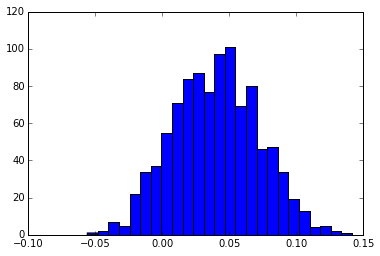

In [256]:
plt.hist(means,bins=25)

In [258]:
cdf_arr[0].x

array([-4.        , -3.91919192, -3.83838384, -3.75757576, -3.67676768,
       -3.5959596 , -3.51515152, -3.43434343, -3.35353535, -3.27272727,
       -3.19191919, -3.11111111, -3.03030303, -2.94949495, -2.86868687,
       -2.78787879, -2.70707071, -2.62626263, -2.54545455, -2.46464646,
       -2.38383838, -2.3030303 , -2.22222222, -2.14141414, -2.06060606,
       -1.97979798, -1.8989899 , -1.81818182, -1.73737374, -1.65656566,
       -1.57575758, -1.49494949, -1.41414141, -1.33333333, -1.25252525,
       -1.17171717, -1.09090909, -1.01010101, -0.92929293, -0.84848485,
       -0.76767677, -0.68686869, -0.60606061, -0.52525253, -0.44444444,
       -0.36363636, -0.28282828, -0.2020202 , -0.12121212, -0.04040404,
        0.04040404,  0.12121212,  0.2020202 ,  0.28282828,  0.36363636,
        0.44444444,  0.52525253,  0.60606061,  0.68686869,  0.76767677,
        0.84848485,  0.92929293,  1.01010101,  1.09090909,  1.17171717,
        1.25252525,  1.33333333,  1.41414141,  1.49494949,  1.57

In [238]:
class EmpericalDistribution(stats.rv_continuous):
    
    def SetParameters(self,x,p,d_type='cdf'):
        p = np.array(p)[np.argsort(x)]
        self.x = np.array(x)[np.argsort(x)]
        
        if d_type == 'pdf':
            self.p = np.cumsum(p)
        else:
            self.p = p
        
        
    
    def _cdf(self,check_x):
        if np.all(check_x < self.x):
            return 0.0
        
        if np.all(check_x > self.x):
            return 1.0
        
        diff = check_x - self.x
        mask = diff < 0.
        
        masked_diff = np.ma.masked_array(diff, mask)
        return self.p[masked_diff.argmin()]

In [109]:
dp.p

[0.2183850826968432,
 0.78131196631067978,
 0.19299689233354664,
 0.010697301704192152,
 0.0037585826834016633,
 0.0094372690352094359,
 0.001789514262302305,
 6.777355704258306e-06,
 4.3939264958602757e-07,
 8.9026124561464268e-07]

In [171]:
cdf = CDF(np.array([0,1,2,3]),np.array([0.1,0.3,0.95,1.0]))

In [154]:
diff = -0.5 - np.array([0,1,2,3])
print diff
mask = diff < 0
print mask
masked_diff = np.ma.masked_array(diff,mask)
print masked_diff
print masked_diff.argmin()

[-0.5 -1.5 -2.5 -3.5]
[ True  True  True  True]
[-- -- -- --]
0


In [64]:
g_grid = rv.cdf(foo)
g_diff = g_grid[1:] - g_grid[:-1]
p = stats.dirichlet.rvs(g_diff * 0.1)

In [32]:
len(cdf_arr[0].x)
(10./(10.+1))**10000

0.0

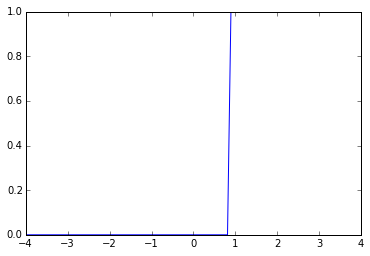

In [67]:
plt.plot(np.linspace(-4,4,99),sum)

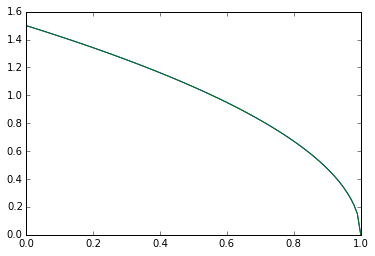

In [81]:
a = 1
b = 1.5
foo = np.linspace(0,1,100)
beta = stats.beta(a,b)
plt.plot(foo,beta.pdf(foo))
plt.plot(foo,stats.beta.pdf(foo,a,b))